In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


### Split Data Train dan Validasi

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path dataset asli
data_dir = "/content/drive/MyDrive/Tubes DL"
train_dir = "/content/drive/MyDrive/dataset_tubes_split/train"
valid_dir = "/content/drive/MyDrive/dataset_tubes_split/valid"
test_dir = "/content/drive/MyDrive/dataset_tubes_split/test"

# Membuat folder train, valid, dan test jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Membaca semua subfolder (misalnya 'normal', 'abnormal')
categories = os.listdir(data_dir)

# Memproses setiap kategori (subfolder)
for category in categories:
    category_path = os.path.join(data_dir, category)

    # Cek jika itu adalah direktori (bukan file)
    if os.path.isdir(category_path):
        # Membaca semua gambar dalam kategori
        all_images = os.listdir(category_path)

        # Membagi data menjadi train (70%) dan sisanya (30%)
        train_images, temp_images = train_test_split(all_images, test_size=0.3, random_state=42)

        # Membagi sisanya (30%) menjadi valid (15%) dan test (15%)
        valid_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

        # Membuat subfolder untuk kategori di dalam folder train, valid, dan test
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(valid_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Menyalin file ke folder train
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))

        # Menyalin file ke folder valid
        for img in valid_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(valid_dir, category, img))

        # Menyalin file ke folder test
        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category, img))

        print(f"Folder '{category}' berhasil dibagi menjadi train, valid, dan test.")


Folder 'abnormal' berhasil dibagi menjadi train, valid, dan test.
Folder 'normal' berhasil dibagi menjadi train, valid, dan test.


In [3]:
import os
def count_files(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        total += len(files)
    return total

print(f"Train Normal: {count_files(os.path.join(train_dir, 'normal'))}")
print(f"Train Abnormal: {count_files(os.path.join(train_dir, 'abnormal'))}")
print(f"Valid Normal: {count_files(os.path.join(valid_dir, 'normal'))}")
print(f"Valid Abnormal: {count_files(os.path.join(valid_dir, 'abnormal'))}")
print(f"Test Normal: {count_files(os.path.join(test_dir, 'normal'))}")
print(f"Test Abnormal: {count_files(os.path.join(test_dir, 'abnormal'))}")


Train Normal: 163
Train Abnormal: 140
Valid Normal: 35
Valid Abnormal: 30
Test Normal: 35
Test Abnormal: 30


### Import Libraries

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize


### Setting dataset Path & Hyperparameters

In [5]:
# Ukuran gambar dan batch size
img_height, img_width = 224, 224  # Meningkatkan ukuran gambar
batch_size = 32  # Mengurangi batch size untuk stabilitas pelatihan

### Data Preprocessing & Augmentasi

In [6]:
# ImageDataGenerator untuk training dan validasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Mengurangi rotation range
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,  # Mengurangi shear range
    zoom_range=0.1,   # Mengurangi zoom range
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Data training
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',  # Menggunakan RGB
    class_mode='binary'
)

# Data validasi
val_data = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',  # Menggunakan RGB
    class_mode='binary'
)

Found 303 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


# **Model 1**

Learning Rate = 1e-4, Droput = 0.3, Frozen Layers = Semua kecuali Layer 2, Epoch = 50, dan Optimizer = Adam

### Membangun Model

In [7]:
# Menggunakan VGG16 sebagai base model
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Pre-trained weights dari ImageNet
    include_top=False,   # Menghapus fully connected layer terakhir
    input_shape=(img_height, img_width, 3)  # Input shape untuk RGB
)

# Membekukan beberapa layer terakhir dari base model untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-2]:  # Membekukan lebih sedikit layer
    layer.trainable = False

# Menambahkan fully connected layers di atas base model
model = models.Sequential([
    base_model,
    layers.Flatten(),  # Flatten output convolusi
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.3),  # Mengurangi dropout
    layers.Dense(1, activation='sigmoid')  # Output layer untuk binary classification
])

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Learning rate yang sedikit lebih tinggi
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 5,571,329 (21.25 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

### Call & Training

In [8]:
# Callback EarlyStopping untuk menghentikan pelatihan jika tidak ada perbaikan
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training model dengan data augmentation tanpa workers
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Meningkatkan jumlah epochs
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5617 - loss: 0.6923 - val_accuracy: 0.7077 - val_loss: 0.5524
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 666ms/step - accuracy: 0.7203 - loss: 0.5509 - val_accuracy: 0.6615 - val_loss: 0.5196
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7606 - loss: 0.4769 - val_accuracy: 0.6769 - val_loss: 0.5117
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - accuracy: 0.7933 - loss: 0.4328 - val_accuracy: 0.8000 - val_loss: 0.4112
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 614ms/step - accuracy: 0.8306 - loss: 0.3289 - val_accuracy: 0.9538 - val_loss: 0.2370
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 627ms/step - accuracy: 0.9085 - loss: 0.2334 - val_accuracy: 0.9231 - val_loss: 0.1948
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 507ms/step - accuracy: 0.9283 - loss: 0.1977 - val_accuracy: 0.8615 - val_loss: 0.2853
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 447ms/step - accuracy: 0.8487 - loss: 0.2951 - val_accuracy: 0.9538 - va

### Plot Hitory Training

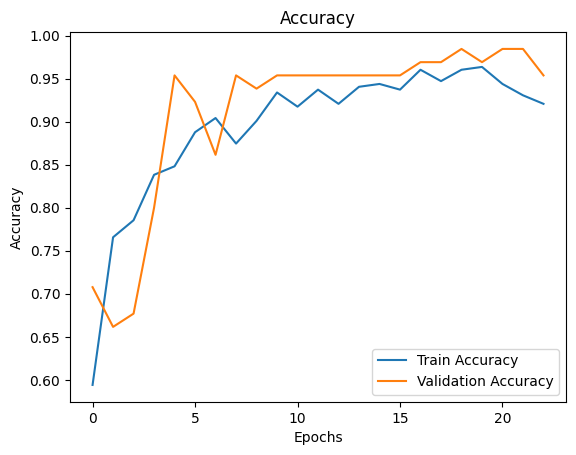

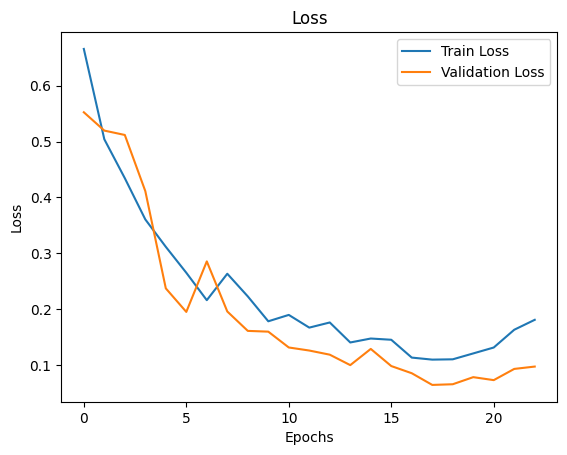

In [9]:
# Visualisasi akurasi dan loss selama pelatihan
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluasi Model Data Validasi

In [10]:
# Evaluasi model pada data validasi
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 580ms/step - accuracy: 0.9768 - loss: 0.0549
Validation Accuracy: 0.97
Validation Loss: 0.06


### Model Evaluasi Pada Data Test

In [11]:
# Menyiapkan data uji dengan rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Memuat data uji
test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),  # Ukuran gambar yang sama dengan yang digunakan untuk pelatihan
    batch_size=batch_size,
    color_mode='rgb',  # Menggunakan mode warna RGB
    class_mode='binary',  # Untuk klasifikasi biner
    shuffle=False  # Jangan acak data agar urutannya tetap
)

# Prediksi model pada data uji
predictions = model.predict(test_data, verbose=1)

# Mengonversi prediksi ke label biner (0 atau 1) dengan threshold 0.5
predicted_labels = (predictions > 0.5).astype("int32")

# Mengambil label asli dari data uji
true_labels = test_data.classes


Found 65 images belonging to 2 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step


### Confusion Matrix & Klafikasi Report

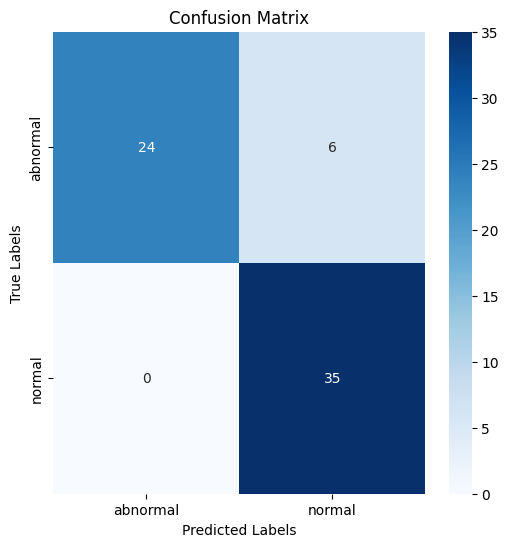

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.85      1.00      0.92        35

    accuracy                           0.91        65
   macro avg       0.93      0.90      0.90        65
weighted avg       0.92      0.91      0.91        65



In [12]:
# Menghitung matriks kebingunguan
cm = confusion_matrix(true_labels, predicted_labels)

# Visualisasi matriks kebingunguan
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

### Evaluasi Model dengan ROC AUC

In [13]:
# Menghitung ROC AUC Score
# Prediksi probabilitas untuk kelas positif (label 1)
predicted_probs = model.predict(test_data, verbose=1)

# Menggunakan label biner untuk ROC AUC
# Jika dataset adalah binary, kita cukup menggunakan predicted_probs untuk kelas 1
roc_auc = roc_auc_score(true_labels, predicted_probs)

print(f"ROC AUC Score: {roc_auc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 497ms/step
ROC AUC Score: 0.9857


### Plot Kurva ROC

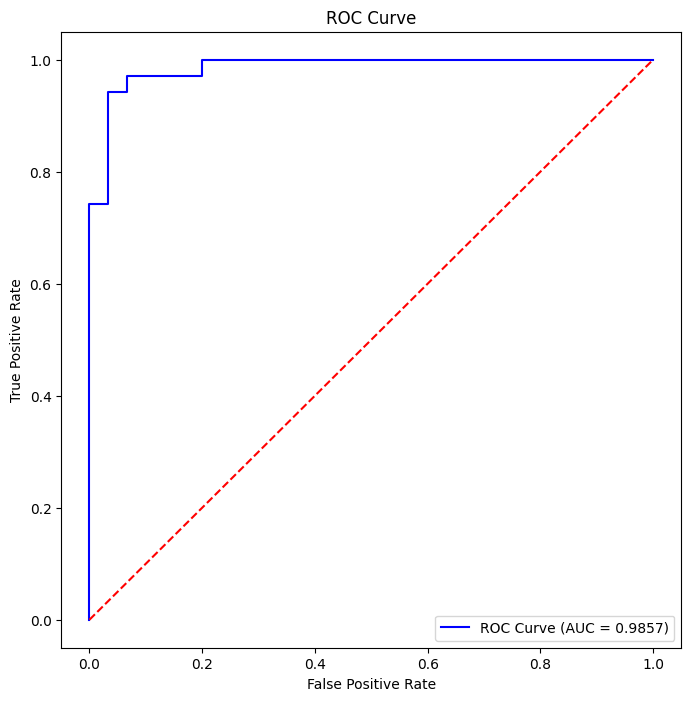

In [14]:
# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Visualisasi ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Line diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [15]:
# Menampilkan hasil prediksi dan label aktual
print("\nPredictions vs Actual Labels:")
for i in range(len(test_data.filepaths)):
    actual_label = test_data.classes[i]  # Label asli
    predicted_label = predicted_labels[i][0]  # Prediksi model
    print(f"File: {test_data.filepaths[i]} | Predicted: {predicted_label} | Actual: {actual_label}")

# Mapping numerik ke nama kelas
class_indices = {v: k for k, v in test_data.class_indices.items()}
print("\nClass Mapping:", class_indices)



Predictions vs Actual Labels:
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(10).jpg | Predicted: 1 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(104).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(121).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(125).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(134).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(142).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(145).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(146).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(155).jpg | Predicted: 1 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/tes

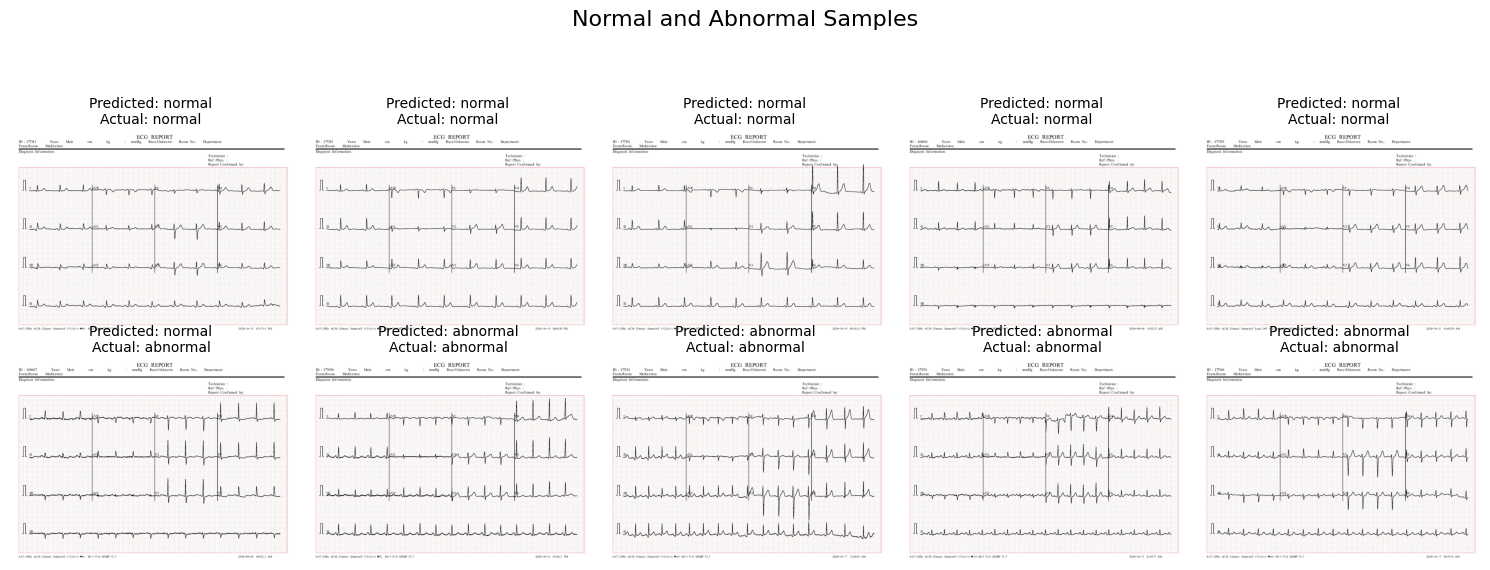

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Mapping numerik ke nama kelas
class_indices = {v: k for k, v in test_data.class_indices.items()}

# List untuk menyimpan indeks gambar berdasarkan kelas
normal_indices = []
abnormal_indices = []

# Cari indeks untuk kelas normal dan abnormal
for i in range(len(test_data.filepaths)):
    actual_label = test_data.classes[i]  # Ambil label aktual
    if class_indices[actual_label] == "normal":
        normal_indices.append(i)
    elif class_indices[actual_label] == "abnormal":
        abnormal_indices.append(i)

# Ambil 5 indeks pertama dari masing-masing kelas
num_samples = 5
selected_indices = normal_indices[:num_samples] + abnormal_indices[:num_samples]

# Plot gambar
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))  # 2 baris, 5 kolom
fig.suptitle("Normal and Abnormal Samples", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i >= len(selected_indices):
        break

    index = selected_indices[i]
    filepath = test_data.filepaths[index]
    actual_label = class_indices[test_data.classes[index]]
    predicted_label = class_indices[predicted_labels[index][0]]

    # Load gambar
    img = plt.imread(filepath)

    # Tampilkan gambar di subplot
    ax.imshow(img)
    ax.axis('off')

    # Tampilkan prediksi dan label aktual
    ax.set_title(
        f"Predicted: {predicted_label}\nActual: {actual_label}",
        fontsize=10
    )

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Tambahkan ruang untuk judul
plt.show()


# **Model 2**

Learning Rate = 1e-3, Droput = 0.5, Frozen Layers = Semua kecuali Layer 5, Batch Size = 64, Epoch = 100, dan Optimizer = Adam

### Membangun Model

In [27]:
# Menggunakan VGG16 sebagai base model
base_model_2 = tf.keras.applications.VGG16(
    weights='imagenet',  # Pre-trained weights dari ImageNet
    include_top=False,   # Menghapus fully connected layer terakhir
    input_shape=(img_height, img_width, 3)  # Input shape untuk RGB
)

# Membekukan beberapa layer terakhir dari base model untuk fine-tuning
base_model_2.trainable = True
for layer in base_model.layers[:-5]:  # Membekukan lebih banyak layer
    layer.trainable = False

# Menambahkan fully connected layers di atas base model
model_2 = models.Sequential([
    base_model,
    layers.Flatten(),  # Flatten output convolusi
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Ubah dropout menjadi lebih tinggi
    layers.Dense(1, activation='sigmoid')  # Output layer untuk binary classification
])

# Kompilasi model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 10,290,945 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### Call & Training

In [28]:
# Callback EarlyStopping untuk menghentikan pelatihan jika tidak ada perbaikan
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training model dengan data augmentation tanpa workers
history_2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    batch_size=64,  # Coba ukuran batch lebih besar
    callbacks=[early_stopping]
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - accuracy: 0.5648 - loss: 0.6855 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - accuracy: 0.5699 - loss: 0.6838 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 355ms/step - accuracy: 0.5405 - loss: 0.6906 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 383ms/step - accuracy: 0.5046 - loss: 0.6964 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - accuracy: 0.5446 - loss: 0.6904 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 672ms/step - accuracy: 0.5452 - loss: 0.6901 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 722ms/step - accuracy: 0.5848 - loss: 0.6835 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 479ms/step - accuracy: 0.5335 - loss: 0.6933 - v

### Plot Hitory Training

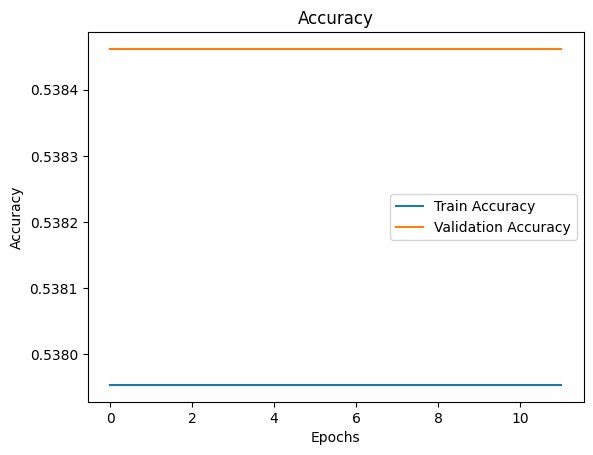

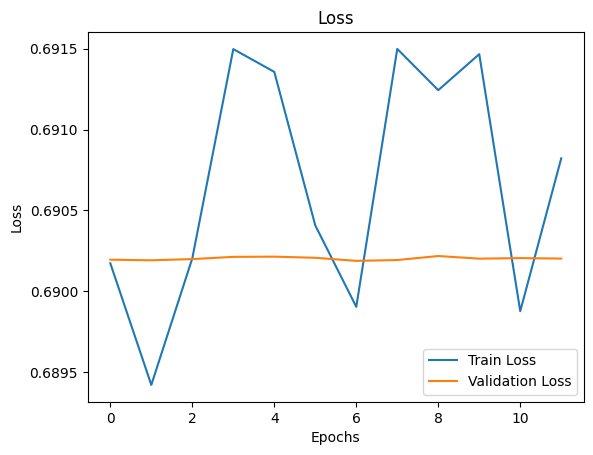

In [29]:
# Visualisasi akurasi dan loss selama pelatihan
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluasi Model Data Validasi

In [30]:
# Evaluasi model pada data validasi
val_loss, val_acc = model_2.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - accuracy: 0.4941 - loss: 0.7123
Validation Accuracy: 0.46
Validation Loss: 0.73


### Model Evaluasi Pada Data Test

In [31]:
# Menyiapkan data uji dengan rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Memuat data uji
test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),  # Ukuran gambar yang sama dengan yang digunakan untuk pelatihan
    batch_size=batch_size,
    color_mode='rgb',  # Menggunakan mode warna RGB
    class_mode='binary',  # Untuk klasifikasi biner
    shuffle=False  # Jangan acak data agar urutannya tetap
)

# Prediksi model pada data uji
predictions = model_2.predict(test_data, verbose=1)

# Mengonversi prediksi ke label biner (0 atau 1) dengan threshold 0.5
predicted_labels = (predictions > 0.5).astype("int32")

# Mengambil label asli dari data uji
true_labels = test_data.classes


Found 65 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step


### Confusion Matrix & Klafikasi Report

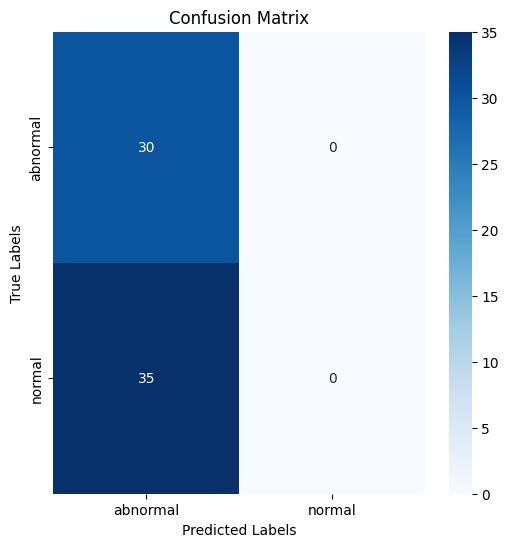

Classification Report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63        30
           1       0.00      0.00      0.00        35

    accuracy                           0.46        65
   macro avg       0.23      0.50      0.32        65
weighted avg       0.21      0.46      0.29        65



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
# Menghitung matriks kebingunguan
cm = confusion_matrix(true_labels, predicted_labels)

# Visualisasi matriks kebingunguan
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

### Evaluasi Model dengan ROC AUC

In [33]:
# Menghitung ROC AUC Score
# Prediksi probabilitas untuk kelas positif (label 1)
predicted_probs = model_2.predict(test_data, verbose=1)

# Menggunakan label biner untuk ROC AUC
# Jika dataset adalah binary, kita cukup menggunakan predicted_probs untuk kelas 1
roc_auc = roc_auc_score(true_labels, predicted_probs)

print(f"ROC AUC Score: {roc_auc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 738ms/step
ROC AUC Score: 0.7343


### Plot Kurva ROC

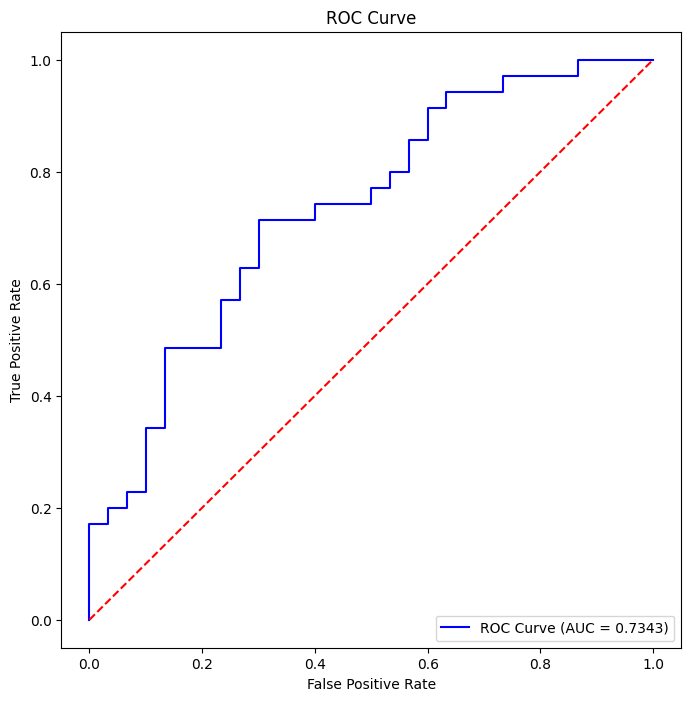

In [34]:
# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Visualisasi ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Line diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [35]:
# Menampilkan hasil prediksi dan label aktual
print("\nPredictions vs Actual Labels:")
for i in range(len(test_data.filepaths)):
    actual_label = test_data.classes[i]  # Label asli
    predicted_label = predicted_labels[i][0]  # Prediksi model
    print(f"File: {test_data.filepaths[i]} | Predicted: {predicted_label} | Actual: {actual_label}")

# Mapping numerik ke nama kelas
class_indices = {v: k for k, v in test_data.class_indices.items()}
print("\nClass Mapping:", class_indices)



Predictions vs Actual Labels:
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(10).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(104).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(121).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(125).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(134).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(142).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(145).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(146).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(155).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/tes

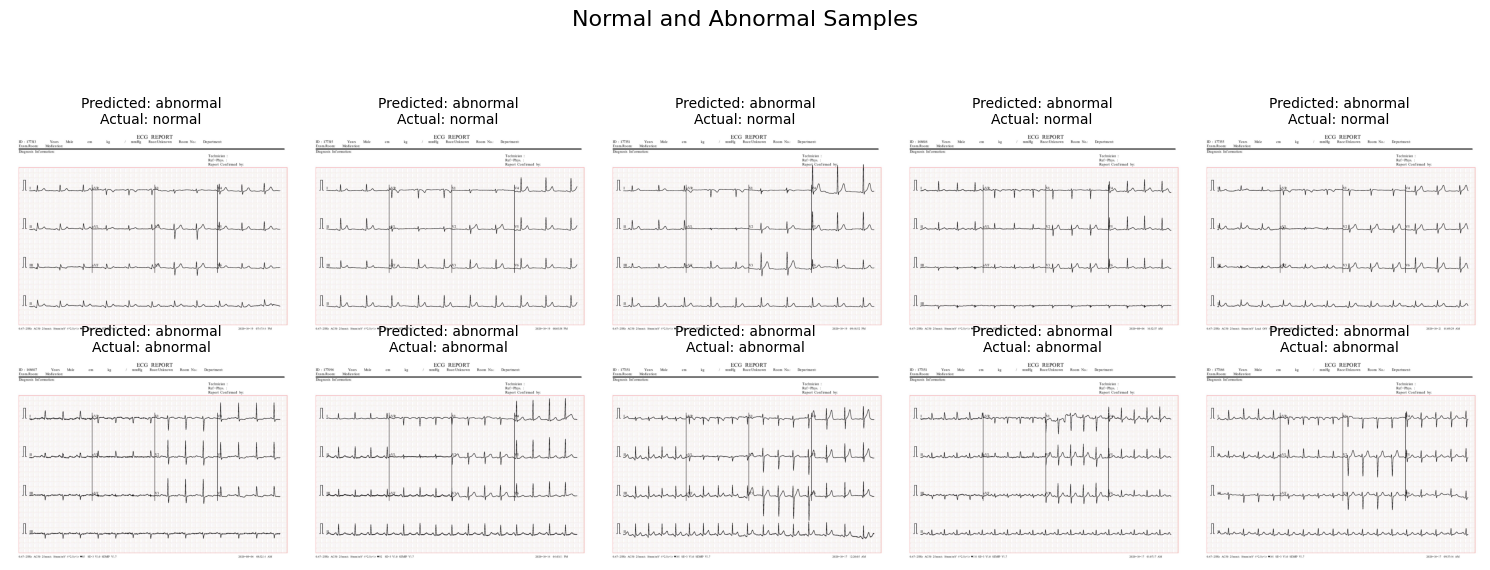

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Mapping numerik ke nama kelas
class_indices = {v: k for k, v in test_data.class_indices.items()}

# List untuk menyimpan indeks gambar berdasarkan kelas
normal_indices = []
abnormal_indices = []

# Cari indeks untuk kelas normal dan abnormal
for i in range(len(test_data.filepaths)):
    actual_label = test_data.classes[i]  # Ambil label aktual
    if class_indices[actual_label] == "normal":
        normal_indices.append(i)
    elif class_indices[actual_label] == "abnormal":
        abnormal_indices.append(i)

# Ambil 5 indeks pertama dari masing-masing kelas
num_samples = 5
selected_indices = normal_indices[:num_samples] + abnormal_indices[:num_samples]

# Plot gambar
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))  # 2 baris, 5 kolom
fig.suptitle("Normal and Abnormal Samples", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i >= len(selected_indices):
        break

    index = selected_indices[i]
    filepath = test_data.filepaths[index]
    actual_label = class_indices[test_data.classes[index]]
    predicted_label = class_indices[predicted_labels[index][0]]

    # Load gambar
    img = plt.imread(filepath)

    # Tampilkan gambar di subplot
    ax.imshow(img)
    ax.axis('off')

    # Tampilkan prediksi dan label aktual
    ax.set_title(
        f"Predicted: {predicted_label}\nActual: {actual_label}",
        fontsize=10
    )

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Tambahkan ruang untuk judul
plt.show()


# **Model 3**

Learning Rate = 1e-4, Droput = 0.2, Frozen Layers = Semua kecuali Layer 10, Batch Size = 16, Epoch = 75, dan Optimizer = SGD (momentum=0.9)

### Membangun Model

In [40]:
# Menggunakan VGG16 sebagai base model
base_model_3 = tf.keras.applications.VGG16(
    weights='imagenet',  # Pre-trained weights dari ImageNet
    include_top=False,   # Menghapus fully connected layer terakhir
    input_shape=(img_height, img_width, 3)  # Input shape untuk RGB
)

# Membekukan beberapa layer terakhir dari base model untuk fine-tuning
base_model_3.trainable = True
for layer in base_model.layers[:-10]:  # Membekukan semua layer kecuali 10
    layer.trainable = False

# Menambahkan fully connected layers di atas base model
model_3 = models.Sequential([
    base_model,
    layers.Flatten(),  # Flatten output convolusi
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.2),  # Mengurangi dropout
    layers.Dense(1, activation='sigmoid')  # Output layer untuk binary classification
])

# Kompilasi model
model_3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),  # Learning rate yang sedikit lebih tinggi
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 10,290,945 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### Call & Training

In [41]:
# Callback EarlyStopping untuk menghentikan pelatihan jika tidak ada perbaikan
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training model dengan data augmentation tanpa workers
history_3 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=75,
    batch_size=16,  # Coba ukuran batch lebih besar
    callbacks=[early_stopping]
)


Epoch 1/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 453ms/step - accuracy: 0.5359 - loss: 0.6915 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 2/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 429ms/step - accuracy: 0.5391 - loss: 0.6899 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 3/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 359ms/step - accuracy: 0.5395 - loss: 0.6926 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 4/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 418ms/step - accuracy: 0.5146 - loss: 0.6933 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 5/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 431ms/step - accuracy: 0.5729 - loss: 0.6866 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 6/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.5626 - loss: 0.6860 - val_accuracy: 0.5385 - val_loss: 0.6902


### Plot Hitory Training

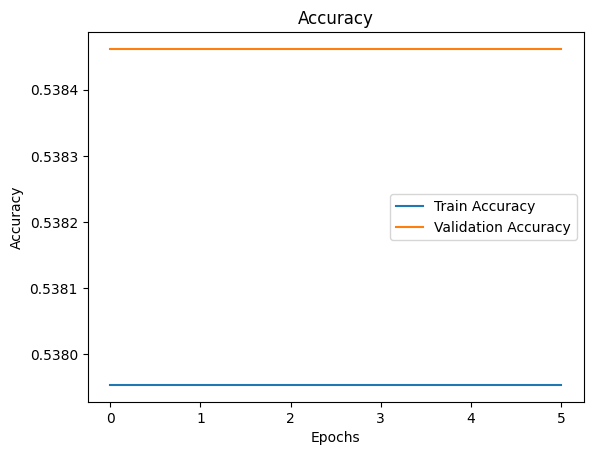

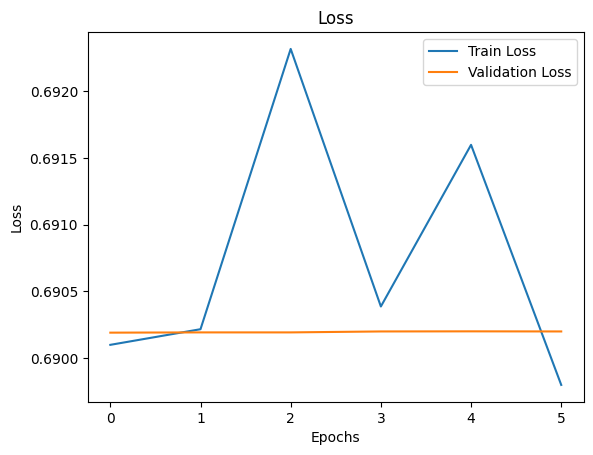

In [42]:
# Visualisasi akurasi dan loss selama pelatihan
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluasi Model Data Validasi

In [43]:
# Evaluasi model pada data validasi
val_loss, val_acc = model_3.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.4854 - loss: 0.7973
Validation Accuracy: 0.46
Validation Loss: 0.82


### Model Evaluasi Pada Data Test

In [44]:
# Menyiapkan data uji dengan rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Memuat data uji
test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),  # Ukuran gambar yang sama dengan yang digunakan untuk pelatihan
    batch_size=batch_size,
    color_mode='rgb',  # Menggunakan mode warna RGB
    class_mode='binary',  # Untuk klasifikasi biner
    shuffle=False  # Jangan acak data agar urutannya tetap
)

# Prediksi model pada data uji
predictions = model_3.predict(test_data, verbose=1)

# Mengonversi prediksi ke label biner (0 atau 1) dengan threshold 0.5
predicted_labels = (predictions > 0.5).astype("int32")

# Mengambil label asli dari data uji
true_labels = test_data.classes


Found 65 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step


### Confusion Matrix & Klafikasi Report

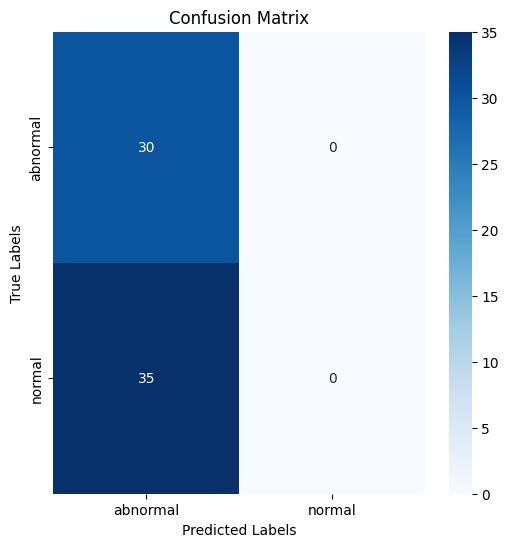

Classification Report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63        30
           1       0.00      0.00      0.00        35

    accuracy                           0.46        65
   macro avg       0.23      0.50      0.32        65
weighted avg       0.21      0.46      0.29        65



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
# Menghitung matriks kebingunguan
cm = confusion_matrix(true_labels, predicted_labels)

# Visualisasi matriks kebingunguan
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

### Evaluasi Model dengan ROC AUC

In [48]:
# Menghitung ROC AUC Score
# Prediksi probabilitas untuk kelas positif (label 1)
predicted_probs = model_3.predict(test_data, verbose=1)

# Menggunakan label biner untuk ROC AUC
# Jika dataset adalah binary, kita cukup menggunakan predicted_probs untuk kelas 1
roc_auc = roc_auc_score(true_labels, predicted_probs)

print(f"ROC AUC Score: {roc_auc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step
ROC AUC Score: 0.2857


### Plot Kurva ROC

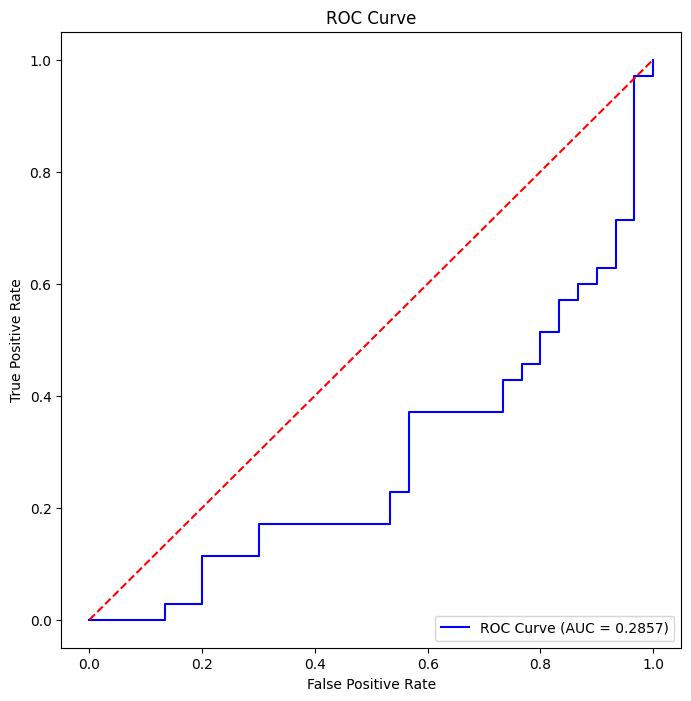

In [49]:
# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Visualisasi ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Line diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [50]:
# Menampilkan hasil prediksi dan label aktual
print("\nPredictions vs Actual Labels:")
for i in range(len(test_data.filepaths)):
    actual_label = test_data.classes[i]  # Label asli
    predicted_label = predicted_labels[i][0]  # Prediksi model
    print(f"File: {test_data.filepaths[i]} | Predicted: {predicted_label} | Actual: {actual_label}")

# Mapping numerik ke nama kelas
class_indices = {v: k for k, v in test_data.class_indices.items()}
print("\nClass Mapping:", class_indices)



Predictions vs Actual Labels:
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(10).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(104).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(121).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(125).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(134).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(142).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(145).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(146).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/test/abnormal/HB(155).jpg | Predicted: 0 | Actual: 0
File: /content/drive/MyDrive/dataset_tubes_split/tes

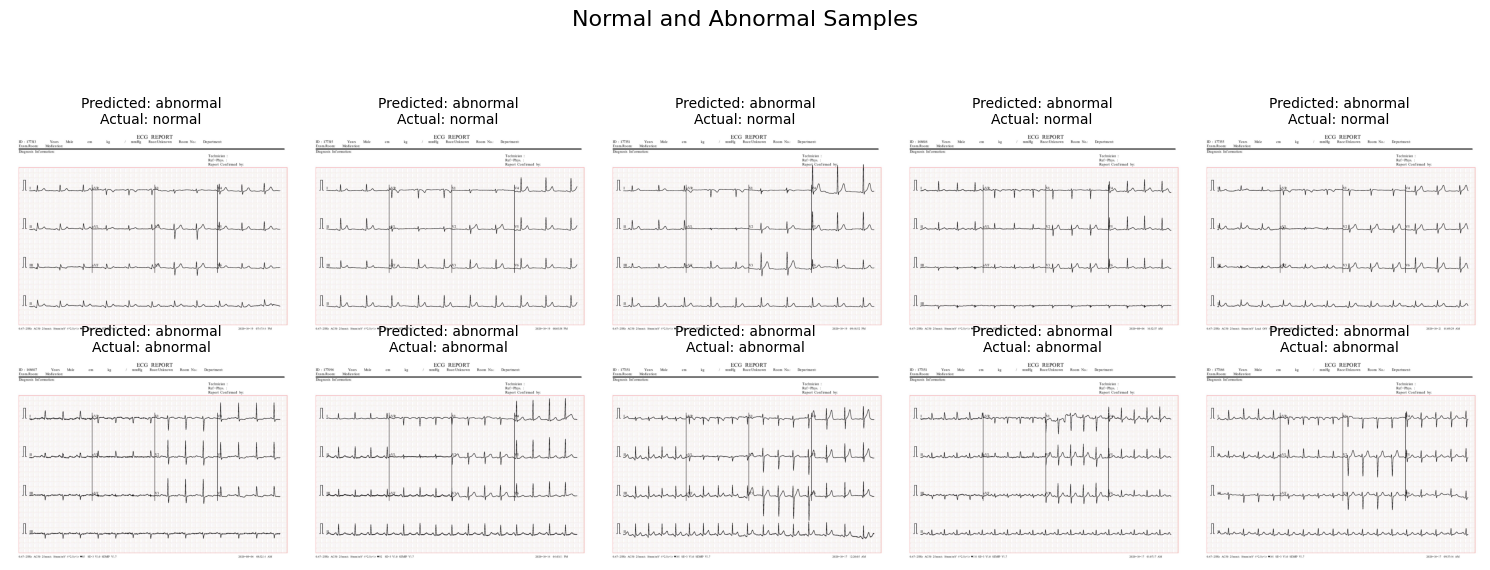

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Mapping numerik ke nama kelas
class_indices = {v: k for k, v in test_data.class_indices.items()}

# List untuk menyimpan indeks gambar berdasarkan kelas
normal_indices = []
abnormal_indices = []

# Cari indeks untuk kelas normal dan abnormal
for i in range(len(test_data.filepaths)):
    actual_label = test_data.classes[i]  # Ambil label aktual
    if class_indices[actual_label] == "normal":
        normal_indices.append(i)
    elif class_indices[actual_label] == "abnormal":
        abnormal_indices.append(i)

# Ambil 5 indeks pertama dari masing-masing kelas
num_samples = 5
selected_indices = normal_indices[:num_samples] + abnormal_indices[:num_samples]

# Plot gambar
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))  # 2 baris, 5 kolom
fig.suptitle("Normal and Abnormal Samples", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i >= len(selected_indices):
        break

    index = selected_indices[i]
    filepath = test_data.filepaths[index]
    actual_label = class_indices[test_data.classes[index]]
    predicted_label = class_indices[predicted_labels[index][0]]

    # Load gambar
    img = plt.imread(filepath)

    # Tampilkan gambar di subplot
    ax.imshow(img)
    ax.axis('off')

    # Tampilkan prediksi dan label aktual
    ax.set_title(
        f"Predicted: {predicted_label}\nActual: {actual_label}",
        fontsize=10
    )

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Tambahkan ruang untuk judul
plt.show()
